In [ ]:
import pandas as pd
import seaborn as sns

In [59]:
df = sns.load_dataset("diamonds")
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [13]:
df.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [15]:
print(df["cut"].unique())
print(df["color"].unique())
print(df["clarity"].unique())

['Ideal', 'Premium', 'Good', 'Very Good', 'Fair']
Categories (5, object): ['Ideal', 'Premium', 'Very Good', 'Good', 'Fair']
['E', 'I', 'J', 'H', 'F', 'G', 'D']
Categories (7, object): ['D', 'E', 'F', 'G', 'H', 'I', 'J']
['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF']
Categories (8, object): ['IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1']


In [23]:
df[["carat", "depth", "table", "price", "x", "y", "x"]].describe()

,carat,depth,table,price,x,y,x
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,5.731157
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,1.121761
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,4.710000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,5.700000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,6.540000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,10.740000


In [24]:
df[["cut", "color", "clarity"]].describe()

,cut,color,clarity
count,53940,53940,53940
unique,5,7,8
top,Ideal,G,SI1
freq,21551,11292,13065


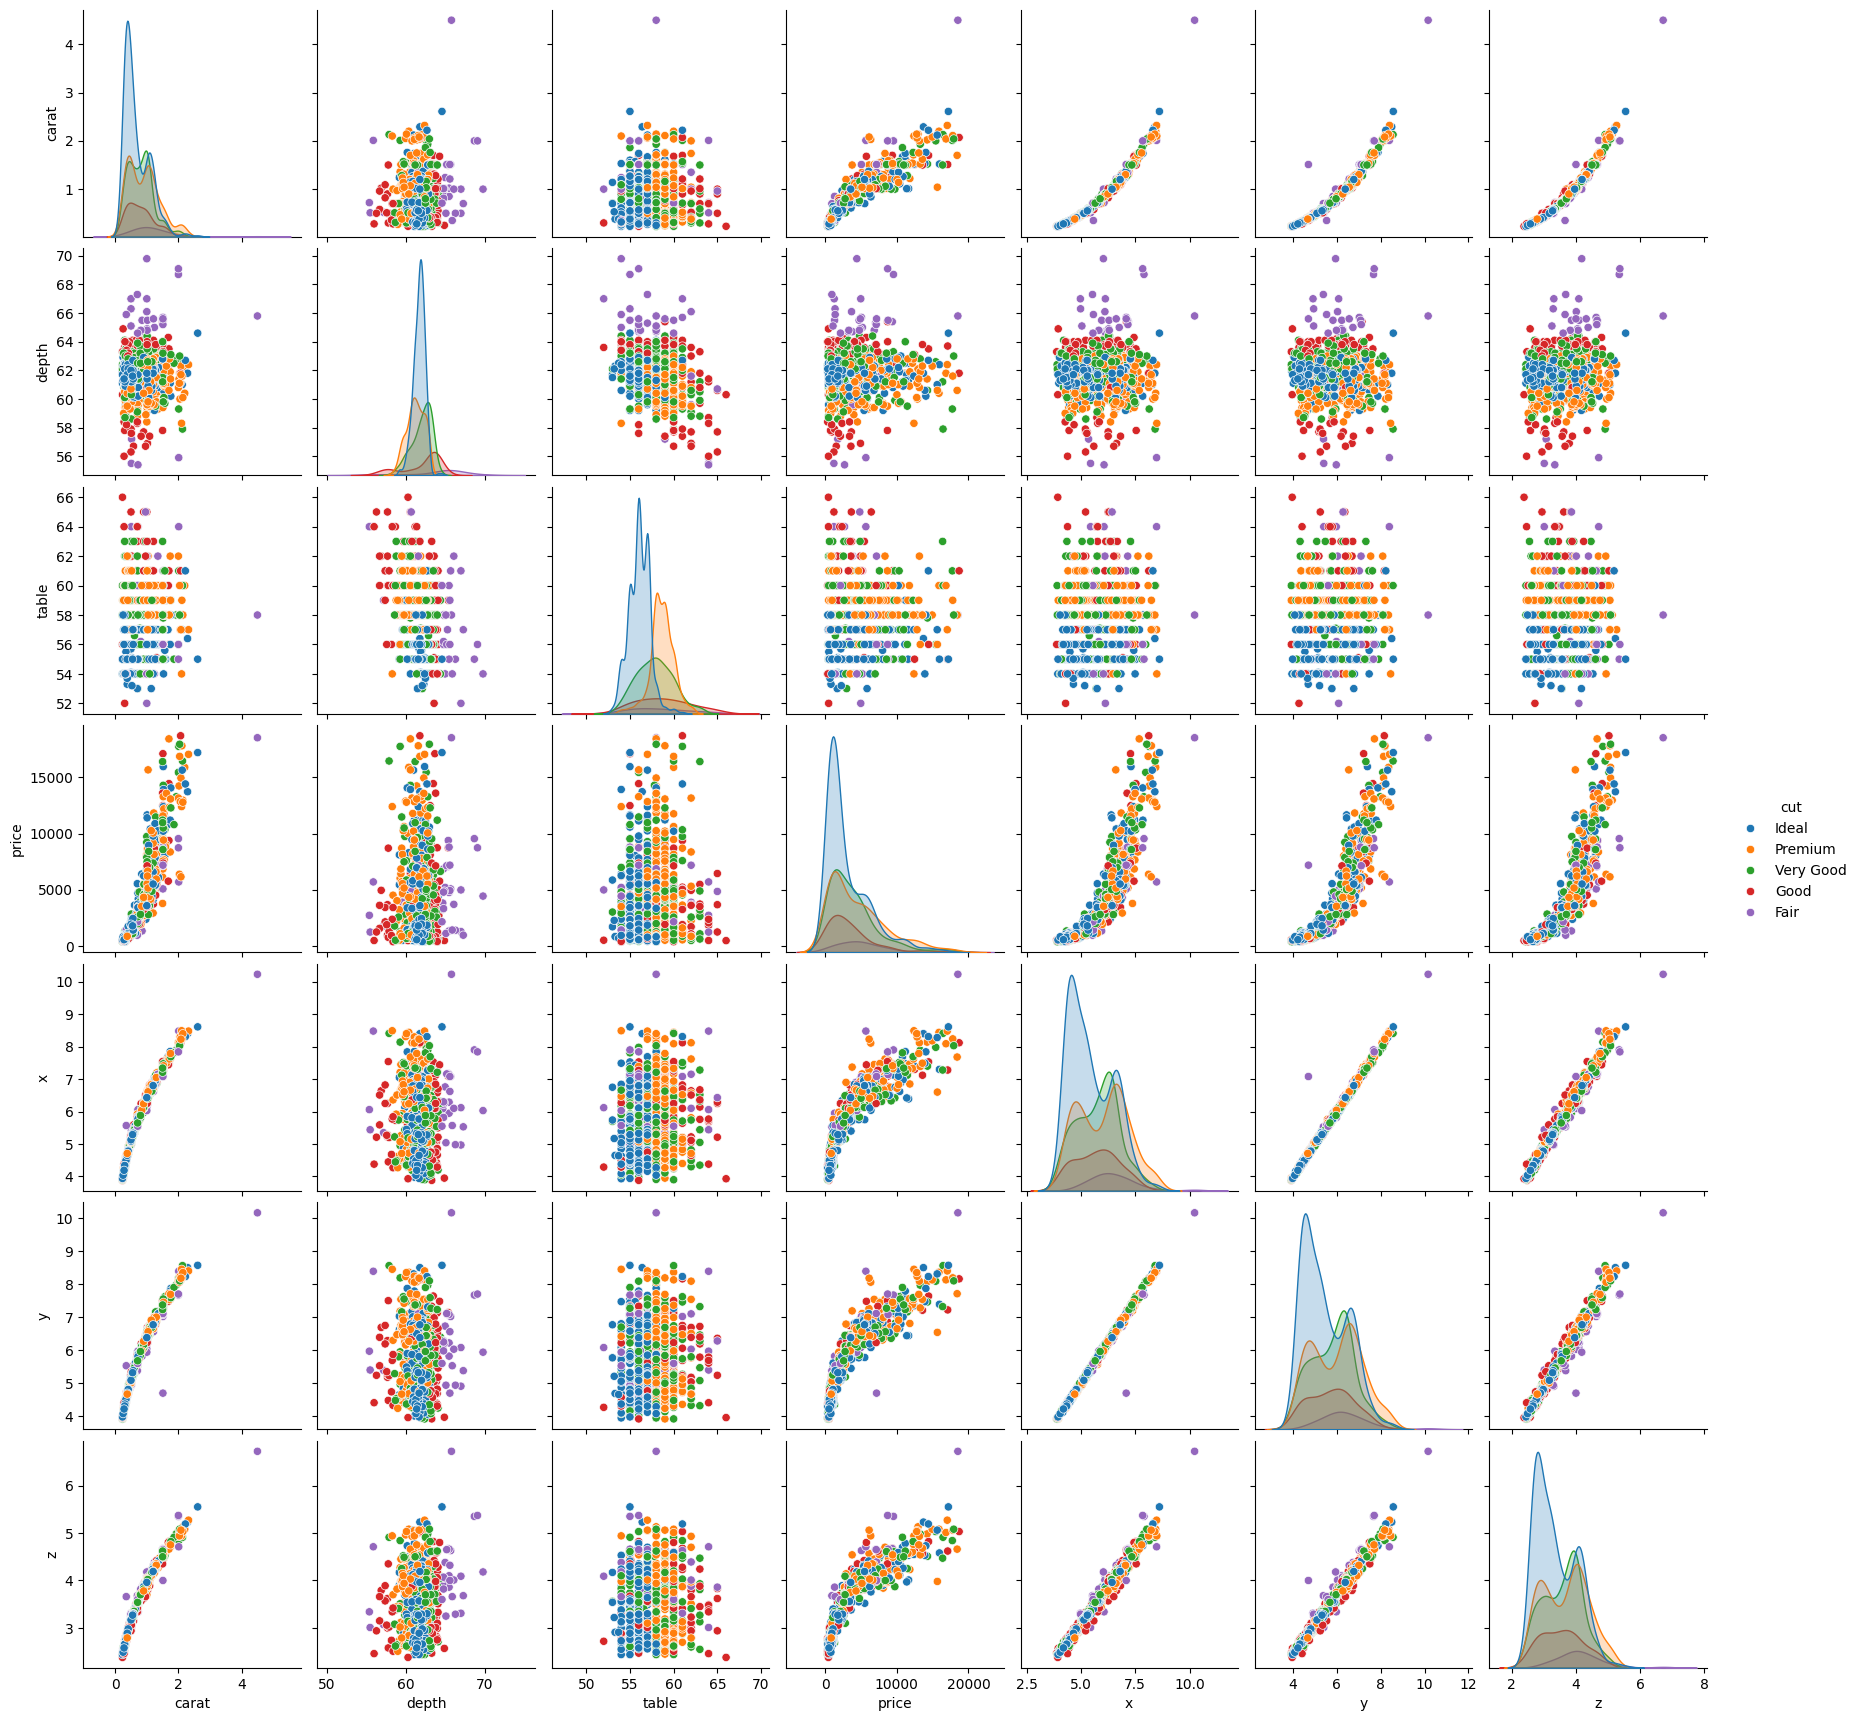

In [88]:
sns.pairplot(df.drop(columns=["color", "clarity"]).sample(frac=1).reset_index(drop=True)[:1000], hue="cut")

In [66]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=["price"]), df["price"], test_size=0.3, random_state=1)

In [ ]:
import os
from dotenv import load_dotenv
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
import mlflow

load_dotenv()
mlflow.set_tracking_uri(os.environ["MLFLOW_TRACKING_URI"])
mlflow.autolog()

ord_encoder = OrdinalEncoder(categories=[
    ["Fair", "Good", "Very Good", "Premium", "Ideal"],
    ["J", "I", "H", "G", "F", "E", "D"],
    ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"],
])

preprocessor = ColumnTransformer(
    transformers=[
        ("ord", ord_encoder, ["cut", "color", "clarity"]),
    ],
    remainder="passthrough",
)

regressor = StackingRegressor([
    ("elastic_net", ElasticNet(alpha=0.05, random_state=1)),
    #("random_forest", RandomForestRegressor(n_estimators=10, random_state=1)),
])

pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", regressor),
])

from sklearn import set_config
set_config(display='diagram')   
pipe

2025/04/21 06:29:29 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  OrdinalEncoder(categories=[['Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal'],
                                                                             ['J',
                                                                              'I',
                                                                              'H',
                                                                              'G',
                                                                              'F',
                                                                              'E',
                                                                              'D'],
                                                                             ['I1',
                                                                              'SI2',
                                                                              'SI1',
                                                                              'VS2',
                                                                              'VS1',
                                                                              'VVS2',
                                                                              'VVS1',
                                                                              'IF']]),
                                                  ['cut', 'color',
                                                   'clarity'])])),
                ('regressor',
                 StackingRegressor(estimators=[('elastic_net',
                                                ElasticNet(alpha=0.05,
                                                           random_state=1))]))])

In [185]:
set_config(display=None)

In [186]:
with mlflow.start_run(run_name='example') as run:
    pipe.fit(X_train, y_train)

pred = pipe.predict(X_test)

2025/04/21 06:29:34 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/kotoji/develop/github-repos/k5ki/notebooks/.venv/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).
"
2025/04/21 06:29:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


🏃 View run example at: http://ghostnaut:15000/#/experiments/0/runs/f220d8b43f694d8b8f3fd4b4d09a6df8
🧪 View experiment at: http://ghostnaut:15000/#/experiments/0


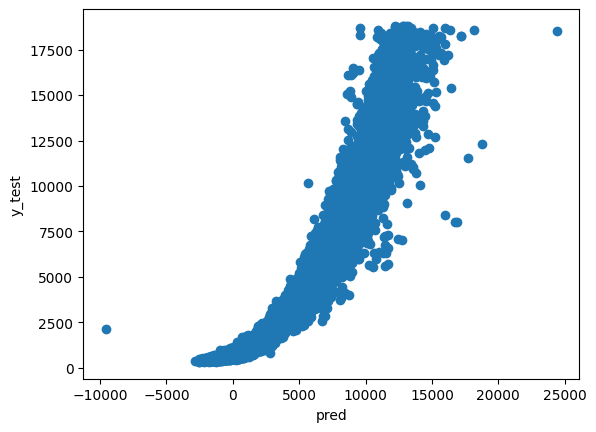

In [187]:
import matplotlib.pyplot as plt

plt.xlabel("pred")
plt.ylabel("y_test")
plt.scatter(pred, y_test)

plt.show()

In [127]:
run = mlflow.search_runs(order_by=["start_time desc"], max_results=1).iloc[0]
mlflow.register_model(model_uri=f"runs:/{run.run_id}/model", name="diamonds_price_pred")

Registered model 'diamonds_price_pred' already exists. Creating a new version of this model...
2025/04/21 05:59:32 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: diamonds_price_pred, version 3
Created version '3' of model 'diamonds_price_pred'.


<ModelVersion: aliases=[], creation_timestamp=1745182772421, current_stage='None', description='', last_updated_timestamp=1745182772421, name='diamonds_price_pred', run_id='fc25a9c1f8af42cf9416760ba4aea07c', run_link='', source='mlflow-artifacts:/0/fc25a9c1f8af42cf9416760ba4aea07c/artifacts/model', status='READY', status_message=None, tags={}, user_id='', version='3'>

In [128]:
model = mlflow.sklearn.load_model(f"models:/diamonds_price_pred/latest")

idx = 100
pred = model.predict(X_test[idx:idx+1])
ans = y_test[idx:idx+1].values
print(f"pred: {pred}, ans: {ans}")

pred: [6835.77970821], ans: [7533]
